<a href="https://colab.research.google.com/github/RiseNShine-sontu/AI_Project/blob/main/Eye_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 99% 729M/736M [00:07<00:00, 111MB/s]
100% 736M/736M [00:07<00:00, 101MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/eye-diseases-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset_dir = '/content/dataset'

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=32,
    image_size=(256, 256),

)

Found 4217 files belonging to 4 classes.


In [10]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 3 0 1 0 0 3 3 3 3 3 2 1 0 1 2 3 0 2 1 3 1 0 2 3 3 2 0 0 1 1]


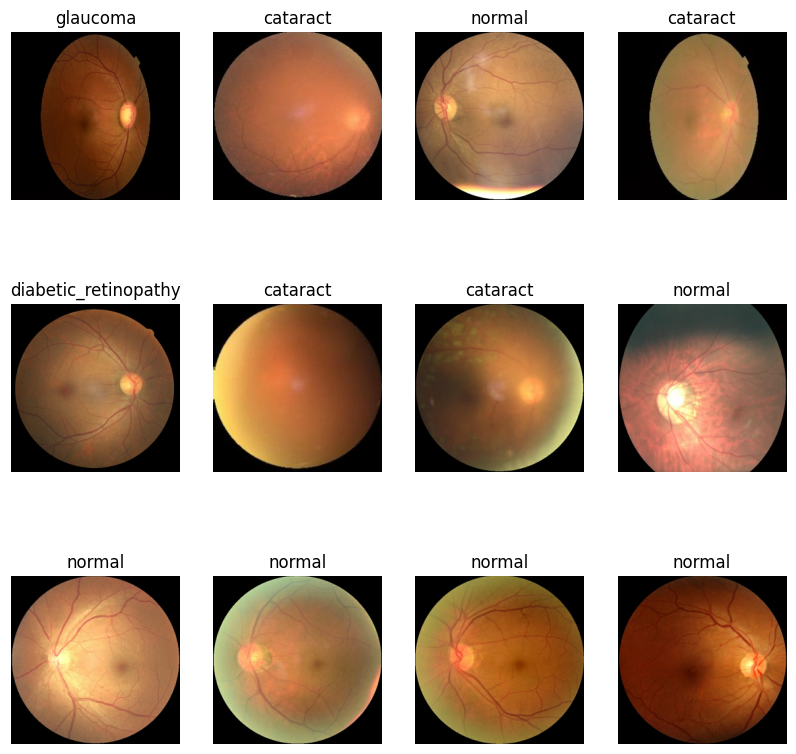

In [12]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax =plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [13]:
train_size = 0.8
len(dataset)*train_size

105.60000000000001

In [14]:
train_ds = dataset.take(105)
len(train_ds)

105

In [15]:
test_ds = dataset.skip(105)
len(test_ds)

27

In [16]:
val_size=0.1
len(dataset)*val_size

13.200000000000001

In [17]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [18]:
test_ds = dataset.skip(13)
len(test_ds)

119

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=40)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(45, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(45, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(45, (3, 3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(45, (3, 3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(45, activation='relu'),
    layers.Dense(n_classes, activation='softmax')\
])
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 45)        13005     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 45)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
105/105 [==============================] - 59s 291ms/step - loss: 1.3090 - accuracy: 0.3797 - val_loss: 1.1452 - val_accuracy: 0.4519
Epoch 2/50
105/105 [==============================] - 6s 56ms/step - loss: 0.9934 - accuracy: 0.5556 - val_loss: 0.9242 - val_accuracy: 0.5745
Epoch 3/50
105/105 [==============================] - 6s 57ms/step - loss: 0.8572 - accuracy: 0.6010 - val_loss: 0.9198 - val_accuracy: 0.6010
Epoch 4/50
105/105 [==============================] - 6s 56ms/step - loss: 0.7701 - accuracy: 0.6514 - val_loss: 0.9225 - val_accuracy: 0.5577
Epoch 5/50
105/105 [==============================] - 6s 55ms/step - loss: 0.6784 - accuracy: 0.7059 - val_loss: 0.7313 - val_accuracy: 0.7019
Epoch 6/50
105/105 [==============================] - 6s 57ms/step - loss: 0.6320 - accuracy: 0.7322 - val_loss: 0.8120 - val_accuracy: 0.7163
Epoch 7/50
105/105 [==============================] - 6s 55ms/step - loss: 0.5914 - accuracy: 0.7575 - val_loss: 0.6765 - val_accuracy: 0.72

In [30]:
len(test_ds)

14

In [31]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 22s 25ms/step - loss: 0.2633 - accuracy: 0.9040


In [32]:
scores

[0.26334860920906067, 0.9040178656578064]

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.3796600103378296,
 0.5556218028068542,
 0.6009543538093567,
 0.6513569951057434,
 0.705935001373291,
 0.732180118560791,
 0.7575305700302124,
 0.7831792235374451,
 0.7882493138313293,
 0.8040560483932495,
 0.8195645809173584,
 0.8237399458885193,
 0.8326871395111084,
 0.829704761505127,
 0.8374589681625366,
 0.8440203070640564,
 0.8556516766548157,
 0.8592305183410645,
 0.8541604280471802,
 0.8577393293380737,
 0.8669847846031189,
 0.8592305183410645,
 0.8684759736061096,
 0.8598270416259766,
 0.8708618879318237,
 0.8690724968910217,
 0.8681777715682983,
 0.8753355145454407,
 0.8762302398681641,
 0.8836862444877625,
 0.8854756951332092,
 0.8845809698104858,
 0.8821950554847717,
 0.8813003301620483,
 0.8863704204559326,
 0.8890545964241028,
 0.8857739567756653,
 0.8821950554847717,
 0.8875633478164673,
 0.8884580731391907,
 0.8833879828453064,
 0.8836862444877625,
 0.8845809698104858,
 0.8902475237846375,
 0.898300051689148,
 0.8932299613952637,
 0.8908440470695496,
 0.89651060104370

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

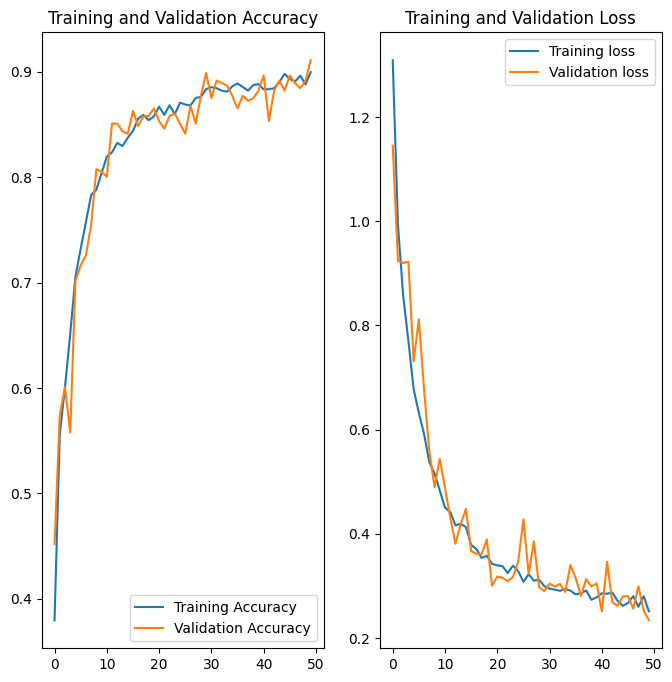

In [36]:
plt.figure(figsize=[8, 8])
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
Label: normal
1/1 [==============================] - 0s 28ms/step
Predicted Label: cataract


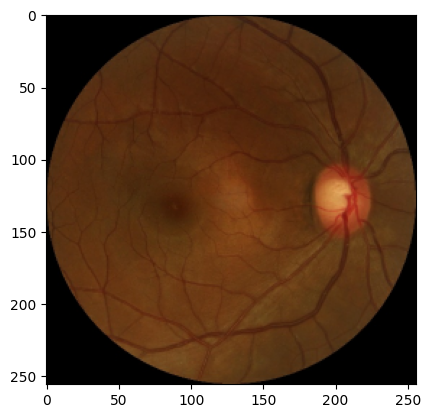

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype("uint8")
  print("First image to predict")
  plt.imshow(first_image)
  print("Label:" ,class_names[labels_batch[0].numpy()])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label:" ,class_names[np.argmax(batch_prediction[0])])

In [43]:
# Convert images into array
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


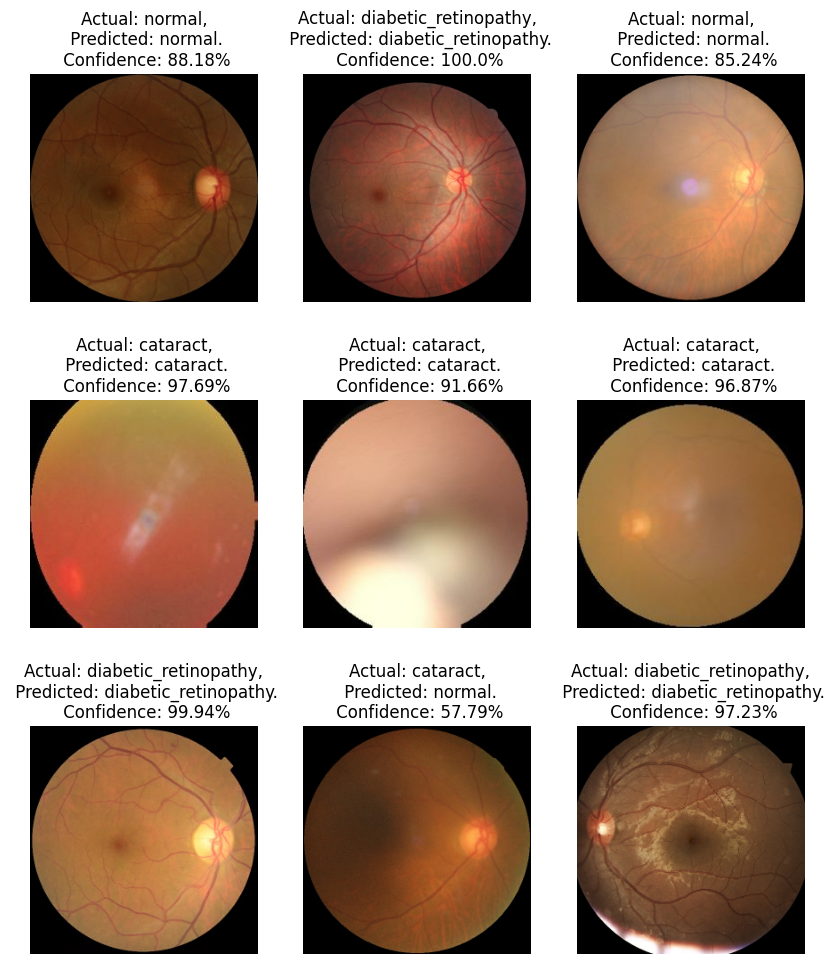

In [48]:
plt.figure(figsize=(10, 12))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())

    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

In [49]:
from tensorflow.keras.models import load_model

In [50]:
model.save('/content/drive/MyDrive/EYE disease')

In [51]:
import os
os.listdir('/content/drive/MyDrive/EYE disease')

['assets',
 'saved_model.pb',
 'variables',
 'fingerprint.pb',
 'keras_metadata.pb']